In [1]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import transforms
from torchvision.transforms import functional as F
plt.style.use('ggplot')

In [3]:
import torchvision
from torchvision import transforms, models

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

val_trans = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
img_path = r"D:\data_class"

In [5]:
ds = ImageFolder(img_path, transform)

In [244]:
target_list = torch.tensor(ds.targets)
target_list = target_list[torch.randperm(len(target_list))]

In [261]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [262]:
idx2class = {v: k for k, v in ds.class_to_idx.items()}

In [263]:
class_count = [i for i in get_class_distribution(ds).values()]

In [264]:
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

In [265]:
class_weights_all = class_weights[target_list]

In [266]:
from torch.utils.data import WeightedRandomSampler

In [122]:
train = int(0.8*len(ds))
val = len(ds) - train
train_ds, val_ds = random_split(ds, lengths=[train, val])

In [123]:
train_dl = DataLoader(train_ds, shuffle=True, batch_size=16)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=16)

In [124]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [125]:
from torchvision import models
from torch import nn

In [141]:
model = models.resnet18(pretrained=True)

model.fc = nn.Sequential(
#     nn.Dropout(),
    nn.Linear(512, 2)
)

model.to(device);

In [142]:
import matplotlib.pyplot as plt
from IPython.display import clear_output 

In [143]:
def train(model, loss_fn, opt, num_epoch, train_dl, val_dl, steps=None, val_steps=None):
    for epoch in range(num_epoch):
        epoch_loss = 0.
        true_class = 0
        for step, (X_tr, y_tr) in enumerate(train_dl):
            if step == steps:
                break
                
            X_tr = X_tr.to(device)
            y_tr = y_tr.to(device)
            y_pred = model(X_tr)
            loss = loss_fn(y_pred, y_tr)
            epoch_loss += loss.item()
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            true_class += (y_pred.argmax(1) == y_tr).sum().item()
            
        tr_spam = epoch_loss / len(train_dl)
        tr_loss.append(tr_spam)
        acc.append(true_class / len(train_ds))

        with torch.no_grad():
            val_epoch_loss = 0.
            true_class = 0
            for val_step, (X_val, y_val) in enumerate(val_dl):
                if val_step == val_steps:
                    break
                    
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_hat = model(X_val)
                val_epoch_loss += loss_fn(y_hat, y_val).item()
                
                true_class += (y_hat.argmax(1) == y_val).sum().item()
            
            val_spam = val_epoch_loss / len(val_dl)
            val_loss.append(val_spam)
            val_acc.append(true_class / len(val_ds))
            
#         print(f'{tr_loss[-1]:.3f}/{val_loss[-1]:.2f}')
        clear_output(True)
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,8))
        ax1.plot(tr_loss, label='Train loss')
        ax1.plot(val_loss, label='Val loss')
        ax1.set_xlabel('Num epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        ax2.plot(acc, label='Train accuracy')
        ax2.plot(val_acc, label='Val accuracy')
        ax2.set_xlabel('Num epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        plt.show();

In [144]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

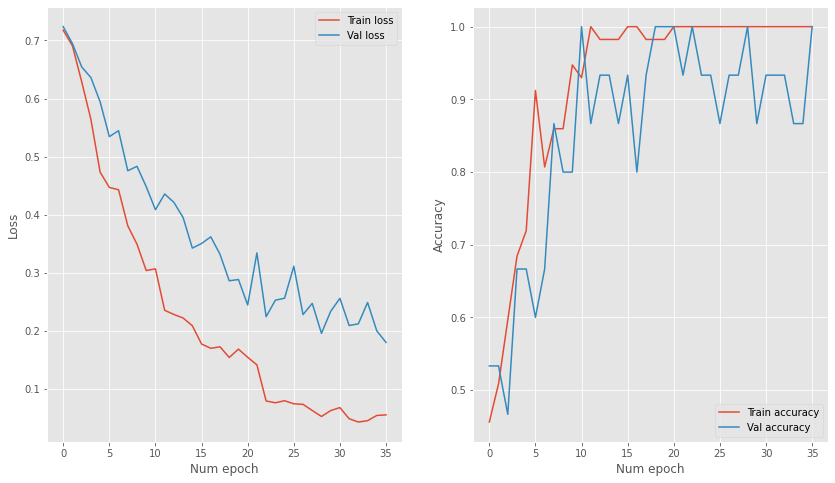

KeyboardInterrupt: 

In [145]:
if True: 
    tr_loss, val_loss, acc, val_acc = [], [], [], []
train(model, loss_fn, opt, 100, train_dl, val_dl)

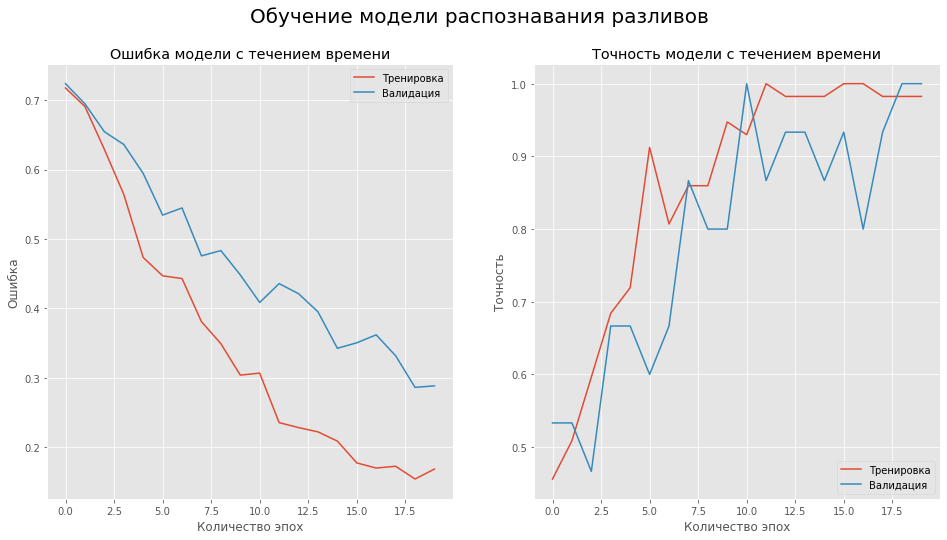

In [160]:
clear_output(True)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Обучение модели распознавания разливов', fontsize=20)
ax1.plot(tr_loss[:20], label='Тренировка')
ax1.plot(val_loss[:20], label='Валидация')
ax1.set_xlabel('Количество эпох')
ax1.set_ylabel('Ошибка')
ax1.legend(loc='upper right')
ax1.set_title('Ошибка модели с течением времени')

ax2.plot(acc[:20], label='Тренировка')
ax2.plot(val_acc[:20], label='Валидация')
ax2.set_xlabel('Количество эпох')
ax2.set_ylabel('Точность')
ax2.legend(loc='lower right')
ax2.set_title('Точность модели с течением времени')

plt.show();

<bound method _AxesBase.set_yticks of <AxesSubplot:title={'center':'Точность модели с течением времени'}, xlabel='Количество эпох', ylabel='Точность'>>

In [ ]:
torch.save(model, 'model.')

In [314]:
img = Image.open(r"D:\Скважины без разливов\Скважины без разливов (38).JPG").resize((1024,1024))

In [316]:
arr = F.to_tensor(img)

In [326]:
target = torch.zeros(3, 1280, 1280)
# source = torch.ones(30, 35, 49)

In [331]:
target[:, :1024, :1024] = arr

In [333]:
target= target[None]

In [340]:
model(target[:, :, y:y+256, x:x+256]).argmax(1)

tensor([0])

In [357]:
from tqdm.notebook import trange
spam = []
with torch.no_grad():
    for y in trange(0, 1024, 4):
        for x in range(0, 1024, 4):
            spam.append(target[0, :, y:y+256, x:x+256].numpy())

In [64]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [65]:
with torch.no_grad():
    true =  []
    pred = []
    for X, y in train_dl:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        true += y.tolist()
        pred += y_pred.argmax(1).tolist()

In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [204]:
precision, recall, thresholds = precision_recall_curve(true, pred)

In [209]:
2*precision*recall / (precision+recall)

array([0.93333333, 0.90909091, 0.88372093, 0.85714286, 0.87804878,
       0.9       , 0.87179487, 0.84210526, 0.81081081, 0.77777778,
       0.74285714, 0.70588235, 0.66666667, 0.625     , 0.58064516,
       0.53333333, 0.48275862, 0.42857143, 0.37037037, 0.30769231,
       0.32      , 0.25      , 0.17391304, 0.09090909, 0.        ])

In [69]:
torch.save(model, 'razliv_class.save')

In [210]:
thresholds[0]

0.40045034885406494

In [211]:
pred > thresholds[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True])

In [182]:
len(c)

24

In [59]:
img = Image.open('ooo.jpg').resize((256,256))

In [60]:
model.cpu()
model.eval();

In [61]:
preds = model(F.to_tensor(img)[None])

In [62]:
preds.argmax(1)

tensor([1])

In [223]:
ds.class_to_idx

{'Razliv': 0, 'Skvazh': 1}

In [164]:
import numpy as np
np.bincount(true)

array([ 3, 21], dtype=int64)

In [66]:
f1_score(true, pred)

0.9090909090909091

In [27]:
true

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]

In [29]:
x, y = next(iter(val_dl))

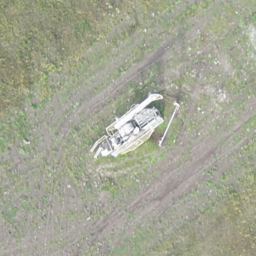

In [41]:
F.to_pil_image(x[7])

In [28]:
pred

[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]

In [57]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
functional_11 (Functional)   (None, 1536)              10783535  
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 3074      
Total params: 10,786,609
Trainable params: 3,458,354
Non-trainable params: 7,328,255
_________________________________________________________________


In [30]:
def plot_activation(img):    
    pred = model(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)

    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]

    intermediate = Model(model.input,
                         model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)

    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])

    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])

    plt.imshow(img.astype('float32').reshape(img.shape[0],
               img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

In [35]:
from PIL import Image
import numpy as np
plot_activation(np.array(Image.open('classif/Skvazh/Скважины без разливов (13)_0_0.JPG')))

ValueError: No such layer: block5_conv3.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import applications
from keras import Model, Input

In [2]:
IMG_SIZE = 300
NUM_CLASSES = 2

In [47]:
base_model.trainable = False

In [52]:
model = Sequential([
    Input((IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    layers.Dropout(0.5),
    layers.Dense(2, activation='sigmoid')
])

In [56]:
inputs = Input((IMG_SIZE, IMG_SIZE, 3)),

In [57]:
x = base_model(inputs)

In [58]:
x = layers.Dropout(0.5)(x)
model = layers.Dense(2, activation='sigmoid')(x)

In [45]:
from keras import Model, Input, Sequential
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False)
# base_model.trainable = False
# base_model = tf.keras.Model([base_model.input], base_model.get_layer("top_dropout").output)

# for i in base_model.layers[-24:]:
#     i.trainable=True

# inputs = Input((IMG_SIZE, IMG_SIZE, 3))
# x = base_model(inputs)
# outputs = Sequential([
#                       layers.Dense(2),
#                       layers.Activation("sigmoid")
#                       ])(x)
# model = Model(inputs, outputs)

43941888/43941136 [==============================] - 23s 1us/step


In [19]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [27]:
train_generator = datagen.flow_from_directory(
    'classif',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    'classif',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='binary',
    subset='validation') # set as validation data

Found 328 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


In [28]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics='accuracy')

In [29]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 16,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 16,
    epochs = 10)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.7628

ValueError: in user code:

    c:\users\rodion\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:1176 test_step
        self.compiled_loss(
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\keras\losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\keras\backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\rodion\venv\lib\site-packages\tensorflow\python\ops\nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))
